In [15]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import glob
import torch
import torch.nn as nn
import tensorflow as tf
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [16]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[]


In [17]:
# # Custom Dataset Class
# class VegetableDataset(Dataset):
#     def __init__(self, folder_path, transform=None):
#         """
#         :param folder_path: Path to the dataset folder (e.g., train, test, or validation).
#         :param transform: Transformations to apply to the images.
#         """
#         self.folder_path = folder_path
#         self.transform = transform
#         self.image_paths = []
#         self.labels = []
#         self.classes = sorted(os.listdir(folder_path))  # List of vegetable types
        
#         # Load all images and labels
#         for label, vegetable in enumerate(self.classes):
#             vegetable_folder = os.path.join(folder_path, vegetable)
#             for img_file in os.listdir(vegetable_folder):
#                 if img_file.lower().endswith(('png', 'jpg', 'jpeg')):
#                     self.image_paths.append(os.path.join(vegetable_folder, img_file))
#                     self.labels.append(label)
    
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         label = self.labels[idx]
#         image = Image.open(image_path).convert("RGB")  # Convert to RGB
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

# # Paths to your dataset folders
# train_folder = "HoledImages/train"
# val_folder = "HoledImages/validation"
# test_folder = "HoledImages/test"

# # Define transformations (resize + normalize)
# transform = transforms.Compose([
#     transforms.Resize((200, 200)),  # Resize images to 200x200
#     transforms.ToTensor(),         # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
# ])

# # Create datasets
# train_dataset = VegetableDataset(train_folder, transform=transform)
# val_dataset = VegetableDataset(val_folder, transform=transform)
# test_dataset = VegetableDataset(test_folder, transform=transform)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Print some stats
# print(f"Train size: {len(train_dataset)}")
# print(f"Validation size: {len(val_dataset)}")
# print(f"Test size: {len(test_dataset)}")
# print(f"Classes: {train_dataset.classes}")


----

In [18]:
class VegetableDataset(Dataset):
    def __init__(self, holed_folder, original_folder, transform=None, limit=None):
        """
        :param holed_folder: Path to the folder with holed images (e.g., HoledImages/train).
        :param original_folder: Path to the folder with original images (e.g., VegetableImages/train).
        :param transform: Transformations to apply to the images.
        :param limit: Limit the number of images loaded (e.g., 100).
        """
        self.holed_folder = holed_folder
        self.original_folder = original_folder
        self.transform = transform
        self.image_pairs = []  # Pairs of (holed_image_path, original_image_path)
        self.classes = sorted(os.listdir(holed_folder))  # List of vegetable types

        # Load image pairs
        for vegetable in self.classes:
            holed_veg_folder = os.path.join(holed_folder, vegetable)
            original_veg_folder = os.path.join(original_folder, vegetable)
            
            holed_images = sorted(os.listdir(holed_veg_folder))
            original_images = sorted(os.listdir(original_veg_folder))

            # Ensure both folders have the same images
            for holed_img, original_img in zip(holed_images, original_images):
                self.image_pairs.append((
                    os.path.join(holed_veg_folder, holed_img),
                    os.path.join(original_veg_folder, original_img)
                ))

        # Apply limit if specified
        if limit:
            self.image_pairs = self.image_pairs[:limit]

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        holed_image_path, original_image_path = self.image_pairs[idx]

        # Load images
        holed_image = Image.open(holed_image_path).convert("RGB")
        original_image = Image.open(original_image_path).convert("RGB")

        # Apply transformations
        if self.transform:
            holed_image = self.transform(holed_image)
            original_image = self.transform(original_image)

        return holed_image, original_image


In [19]:
# Paths to holed and original images
holed_train_folder = "HoledImages/train"
original_train_folder = "VegetableImages/train"

holed_val_folder = "HoledImages/validation"
original_val_folder = "VegetableImages/validation"

# Define transformations (resize + normalize)
# transform = transforms.Compose([
#     transforms.Resize((200, 200)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
transform = transforms.Compose([
    transforms.Resize((200, 200)),  # Resize images to 200x200
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])



# Create datasets
train_dataset = VegetableDataset(holed_train_folder, original_train_folder, transform=transform, limit=1000)
val_dataset = VegetableDataset(holed_val_folder, original_val_folder, transform=transform, limit=40)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


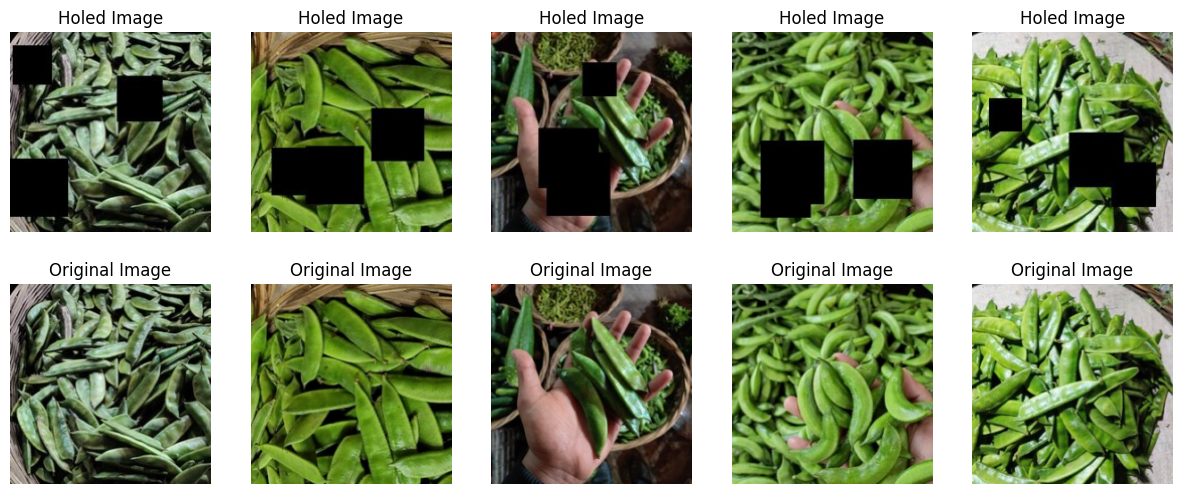

In [20]:
for holed_images, original_images in train_loader:
    # Display holed and original images side-by-side
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axs[0, i].imshow(holed_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        axs[0, i].set_title("Holed Image")
        axs[0, i].axis("off")
        
        axs[1, i].imshow(original_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
        axs[1, i].set_title("Original Image")
        axs[1, i].axis("off")
    plt.show()
    break


-----

## autoencoder-based architecture for inpainting
- Encoder: Compresses the image with the missing regions.
- Decoder: Predicts the missing regions based on the latent representation.

In [21]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 200x200 -> 100x100
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 100x100 -> 50x50
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 50x50 -> 25x25
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),  # 25x25 -> 50x50
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # 50x50 -> 100x100
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=0),  # 100x100 -> 200x200
            nn.Sigmoid()  # Output normalized to [0, 1]
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        # Encoder
        self.encoder1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.encoder2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.encoder3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.ReLU())
        
        # Decoder
        self.decoder3 = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.decoder2 = nn.Sequential(nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.decoder1 = nn.Sequential(nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid())
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        # Decoder with skip connections
        d3 = self.decoder3(e3) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        return d1


# I dont know what I am doing

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedAutoencoder().to(device)

In [24]:
# Pixel-wise reconstruction loss
# criterion = nn.MSELoss()
criterion = nn.L1Loss()


In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [26]:
num_epochs = 65

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for holed_images, original_images in train_loader:  # Input and target
        holed_images, original_images = holed_images.to(device), original_images.to(device)

        # Forward pass
        outputs = model(holed_images)

        # Compute loss
        loss = criterion(outputs, original_images)  # Compare output to ground truth
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [1/65], Loss: 0.5116
Epoch [2/65], Loss: 0.3576
Epoch [3/65], Loss: 0.3421
Epoch [4/65], Loss: 0.3257
Epoch [5/65], Loss: 0.3206
Epoch [6/65], Loss: 0.3148
Epoch [7/65], Loss: 0.3125
Epoch [8/65], Loss: 0.3109
Epoch [9/65], Loss: 0.3077
Epoch [10/65], Loss: 0.3053
Epoch [11/65], Loss: 0.3050
Epoch [12/65], Loss: 0.3026
Epoch [13/65], Loss: 0.2997
Epoch [14/65], Loss: 0.3000
Epoch [15/65], Loss: 0.2988
Epoch [16/65], Loss: 0.2965
Epoch [17/65], Loss: 0.2943
Epoch [18/65], Loss: 0.2922
Epoch [19/65], Loss: 0.2926
Epoch [20/65], Loss: 0.2904
Epoch [21/65], Loss: 0.2908
Epoch [22/65], Loss: 0.2910
Epoch [23/65], Loss: 0.2886
Epoch [24/65], Loss: 0.2892
Epoch [25/65], Loss: 0.2884
Epoch [26/65], Loss: 0.2886
Epoch [27/65], Loss: 0.2874
Epoch [28/65], Loss: 0.2883
Epoch [29/65], Loss: 0.2869
Epoch [30/65], Loss: 0.2862
Epoch [31/65], Loss: 0.2880
Epoch [32/65], Loss: 0.2866
Epoch [33/65], Loss: 0.2855
Epoch [34/65], Loss: 0.2843
Epoch [35/65], Loss: 0.2856
Epoch [36/65], Loss: 0.2854
E

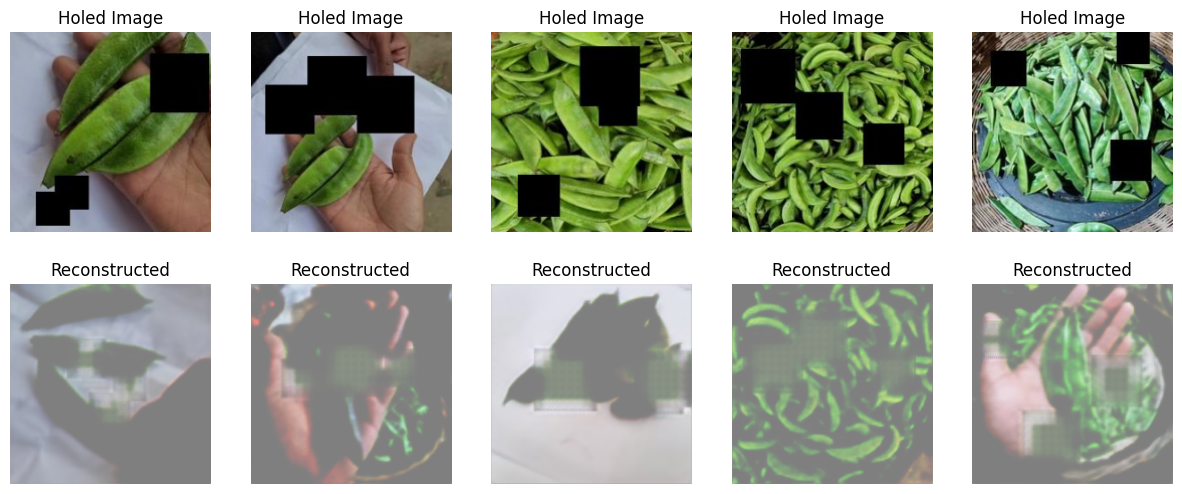

In [27]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        break  # Take the first batch

# Visualize original and reconstructed images
images = images.cpu()
outputs = outputs.cpu()

def unnormalize(img):
    return img * 0.5 + 0.5

# Visualize results
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(unnormalize(holed_images[i].permute(1, 2, 0).cpu().numpy()))
    axs[0, i].set_title("Holed Image")
    axs[0, i].axis("off")
    
    axs[1, i].imshow(unnormalize(outputs[i].permute(1, 2, 0).cpu().numpy()))
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")
plt.show()

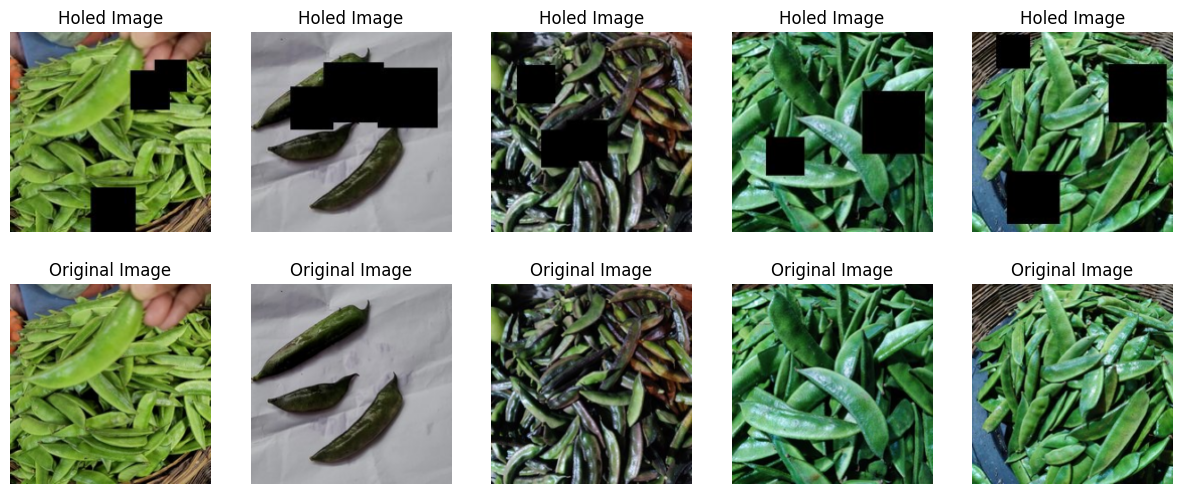

In [28]:
for holed_images, original_images in train_loader:
    # Visualize holed and original images
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(5):
        axs[0, i].imshow(holed_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize
        axs[0, i].set_title("Holed Image")
        axs[0, i].axis("off")

        axs[1, i].imshow(original_images[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)  # Unnormalize
        axs[1, i].set_title("Original Image")
        axs[1, i].axis("off")
    plt.show()
    break
